In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # Untuk menyimpan file .pkl
import warnings

# --- Preprocessing ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# --- Models ---
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# --- Evaluasi ---
from sklearn.metrics import r2_score, mean_absolute_error, classification_report

# --- Konfigurasi ---
sns.set(style='whitegrid')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

print("Semua library berhasil di-import.")

Semua library berhasil di-import.


In [42]:
FILE_NAME = 'company_data.csv'

try:
    df_raw = pd.read_csv(FILE_NAME)
    print(f"--- Berhasil Memuat Data: {FILE_NAME} ---")
    print(f"Bentuk data (Baris, Kolom): {df_raw.shape}\n")

    # --- Info Kolom, Tipe Data, dan Nilai Hilang ---
    print("--- 2. Info Kolom, Tipe Data, dan Nilai Hilang ---")
    df_raw.info()
    
    # --- 5 Baris Data Pertama ---
    print("\n\n--- 3. 5 Baris Data Pertama (Head) ---")
    print(df_raw.head())

except FileNotFoundError:
    print(f"ERROR: File '{FILE_NAME}' tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error: {e}")

--- Berhasil Memuat Data: company_data.csv ---
Bentuk data (Baris, Kolom): (15000, 17)

--- 2. Info Kolom, Tipe Data, dan Nilai Hilang ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Order ID              15000 non-null  int64  
 1   Order Date            15000 non-null  object 
 2   Unit Cost             15000 non-null  float64
 3   Price                 15000 non-null  float64
 4   Order Qty             15000 non-null  int64  
 5   Cost of Sales         15000 non-null  float64
 6   Sales                 15000 non-null  float64
 7   Profit                15000 non-null  float64
 8   Channel               15000 non-null  object 
 9   Promotion Name        15000 non-null  object 
 10  Product Name          15000 non-null  object 
 11  Manufacturer          15000 non-null  object 
 12  Product Sub Category  15000 non-n

--- Menjalankan EDA yang Diperlukan ---


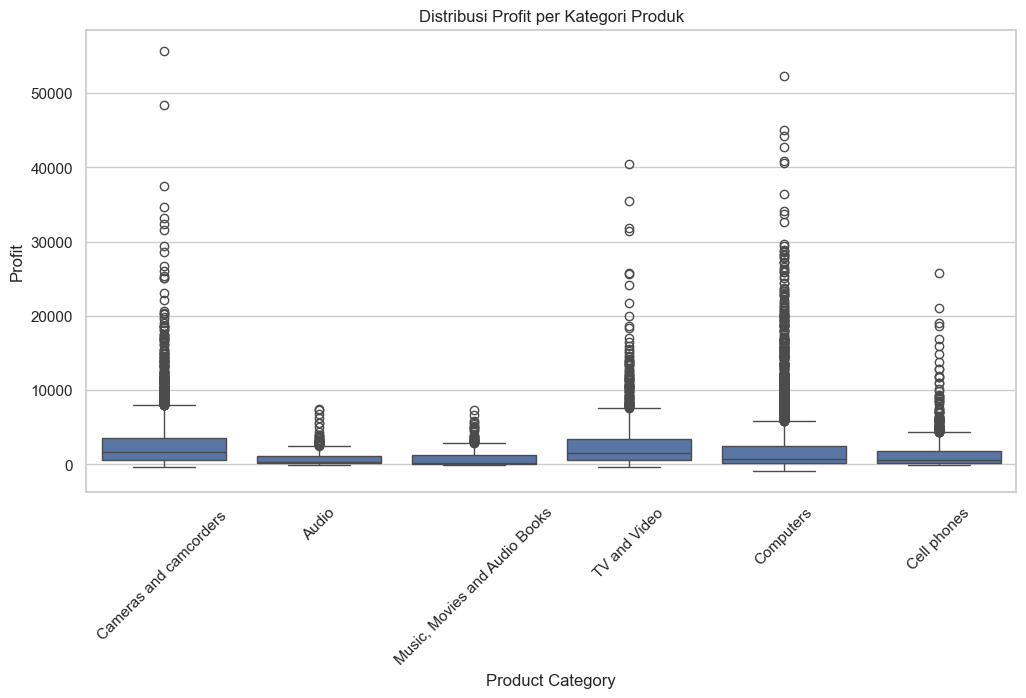

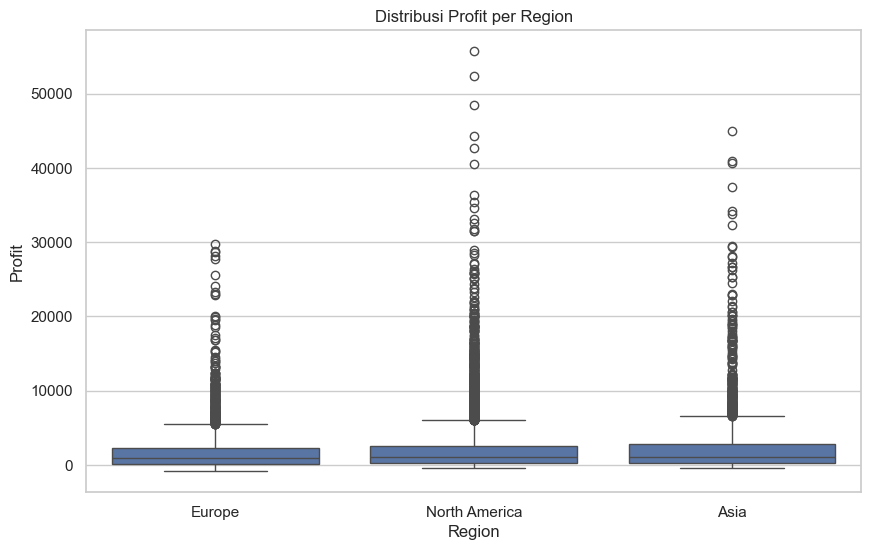

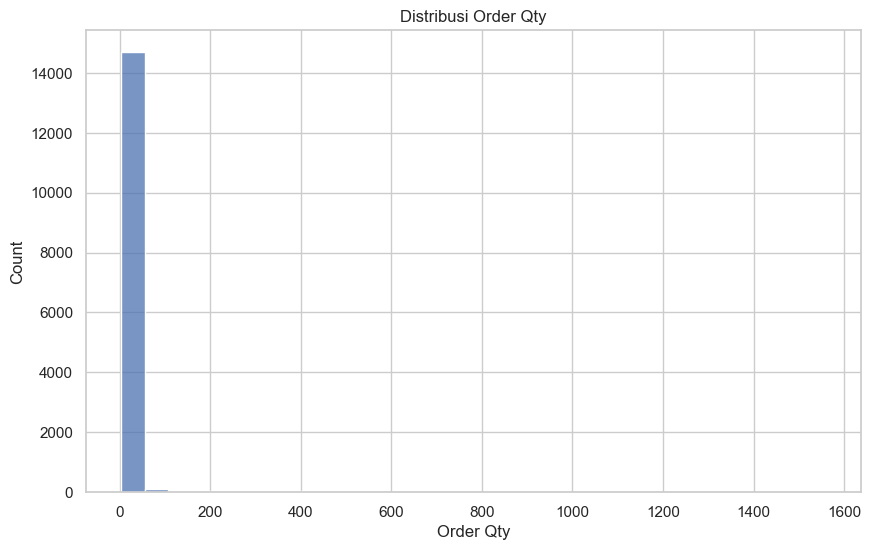

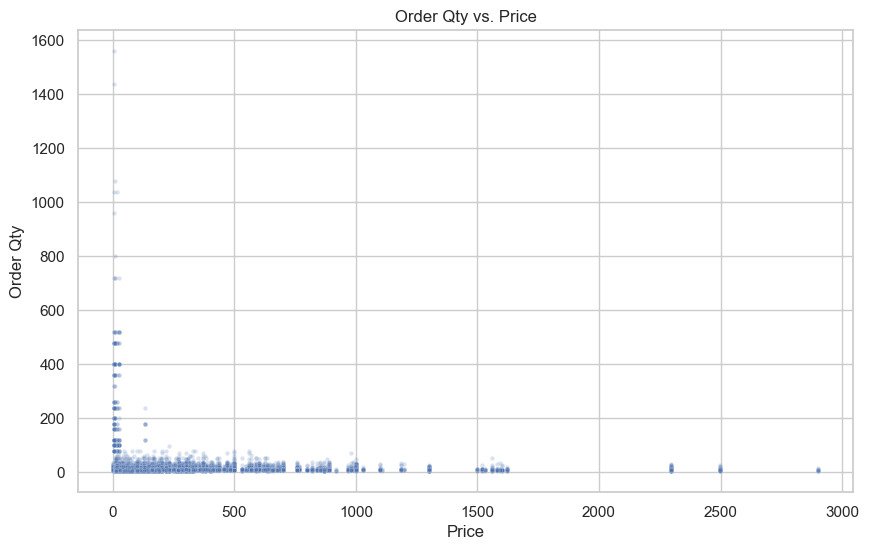

In [43]:
print("--- Menjalankan EDA yang Diperlukan ---")

# --- EDA untuk Model 1 & 3 (Profit) ---
# Apakah Kategori Produk & Region punya profit yang berbeda?

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_raw, x='Product Category', y='Profit')
plt.title('Distribusi Profit per Kategori Produk')
plt.xticks(rotation=45)
plt.show()
# INSIGHT: Jika boxplot ini beda-beda, modelnya BISA belajar.

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_raw, x='Region', y='Profit')
plt.title('Distribusi Profit per Region')
plt.show()
# INSIGHT: Jika ada region yang profitnya beda, ini sinyal bagus.

# --- EDA untuk Model 2 (Order Qty) ---
# 1. Bagaimana distribusi 'Order Qty'? (Bukan 'flat' seperti data kemarin)
plt.figure(figsize=(10, 6))
sns.histplot(df_raw['Order Qty'], kde=False, bins=30)
plt.title('Distribusi Order Qty')
plt.show()
# INSIGHT: Data ini harusnya 'miring ke kanan' (skewed), itu baru data real.

# 2. Apakah ada korelasi (walau kecil) dengan 'Price'?
plt.figure(figsize=(10, 6))
# 'alpha=0.2' untuk buat titik transparan, 's=10' untuk buat titik kecil
sns.scatterplot(data=df_raw, x='Price', y='Order Qty', alpha=0.2, s=10)
plt.title('Order Qty vs. Price')
plt.show()
# INSIGHT: Kita cari pola 'awan' yang miring ke kanan bawah.

In [44]:
def preprocess_data(df_in):
    """
    Membersihkan data, imputasi, dan melakukan feature engineering.
    """
    df = df_in.copy()
    
    # --- 1. Imputasi (Handle Missing Values) ---
    # df.info() menunjukkan tidak ada data hilang, tapi ini best practice
    # Cukup untuk 'object' karena kolom numerik (Price, etc.) lengkap
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].fillna(df[col].mode()[0])

    # --- 2. Feature Engineering (Model 3 Target) ---
    # Buat target 'is_high_profit'
    median_profit = df['Profit'].median()
    df['is_high_profit'] = (df['Profit'] > median_profit).astype(int)
    print(f"Target Model 3 'is_high_profit' dibuat (Median Profit: {median_profit:.2f})")
    
    # --- 3. Feature Engineering (dari 'Order Date') ---
    df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
    df['date_month'] = df['Order Date'].dt.month.astype(str)
    df['date_day_of_week'] = df['Order Date'].dt.dayofweek.astype(str)
    
    # Hapus kolom yang tidak akan dipakai lagi
    df = df.drop(columns=['Order ID', 'Order Date'])
    
    print(f"Data bersih siap: {df.shape}")
    return df

# --- Jalankan fungsi preprocessing ---
df_clean = preprocess_data(df_raw)

Target Model 3 'is_high_profit' dibuat (Median Profit: 1012.68)
Data bersih siap: (15000, 18)


In [45]:
print("--- MEMBANGUN MODEL 1: PREDIKSI PROFIT (REGRESI) ---")

# 1. Definisikan Fitur (X) dan Target (y)
# HANYA fitur kategorikal, TIDAK ADA 'Price', 'Sales', dll. (Anti-Bocor)
FEATURES_M1 = ['Channel', 'Promotion Name', 'Product Name', 'Manufacturer', 
               'Product Sub Category', 'Product Category', 'Region', 'City', 
               'Country', 'date_month', 'date_day_of_week']
TARGET_M1 = 'Profit'

X1 = df_clean[FEATURES_M1]
y1 = df_clean[TARGET_M1]

# 2. Definisikan Preprocessor
# Semua fitur kita kategorikal, jadi kita HANYA butuh OneHotEncoder
preprocessor_m1 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), FEATURES_M1)
    ],
    remainder='passthrough'
)

# 3. Buat Pipeline (Preprocessor + Model)
model_m1 = RandomForestRegressor(random_state=42, n_jobs=-1, max_depth=15)
pipeline_m1 = Pipeline(steps=[
    ('preprocessor', preprocessor_m1),
    ('regressor', model_m1)
])

# 4. Split & Latih Model
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

print(f"Melatih Model 1 pada {len(X1_train)} data...")
pipeline_m1.fit(X1_train, y1_train)
print("Model 1 Selesai.")

# 5. Evaluasi Model 1
y1_pred = pipeline_m1.predict(X1_test)
print("\n--- EVALUASI MODEL 1 (PROFIT) ---")
print(f"R2 Score: {r2_score(y1_test, y1_pred):.3f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y1_test, y1_pred):.2f}")
print(f"(Rata-rata Profit di data test: {y1_test.mean():.2f})")

# 6. Simpan Model 1
joblib.dump(pipeline_m1, 'model_profit_predictor.pkl')
print("\n'model_profit_predictor.pkl' berhasil disimpan.")

--- MEMBANGUN MODEL 1: PREDIKSI PROFIT (REGRESI) ---
Melatih Model 1 pada 12000 data...
Model 1 Selesai.

--- EVALUASI MODEL 1 (PROFIT) ---
R2 Score: 0.435
Mean Absolute Error (MAE): 1324.60
(Rata-rata Profit di data test: 2101.60)

'model_profit_predictor.pkl' berhasil disimpan.


In [46]:
print("\n--- MEMBANGUN MODEL 2: PREDIKSI KUANTITAS (REGRESI) ---")

# 1. Definisikan Fitur (X) dan Target (y)
# Di sini kita BOLEH pakai 'Price' dan 'Unit Cost'
NUMERIC_FEATURES_M2 = ['Unit Cost', 'Price']
CATEGORICAL_FEATURES_M2 = ['Channel', 'Promotion Name', 'Product Category', 
                           'Region', 'date_month', 'date_day_of_week']

FEATURES_M2 = NUMERIC_FEATURES_M2 + CATEGORICAL_FEATURES_M2
TARGET_M2 = 'Order Qty'

X2 = df_clean[FEATURES_M2]
y2 = df_clean[TARGET_M2]

# 2. Definisikan Preprocessor (Numerik + Kategorikal)
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor_m2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERIC_FEATURES_M2),
        ('cat', categorical_transformer, CATEGORICAL_FEATURES_M2)
    ]
)

# 3. Buat Pipeline
model_m2 = RandomForestRegressor(random_state=42, n_jobs=-1, max_depth=10)
pipeline_m2 = Pipeline(steps=[
    ('preprocessor', preprocessor_m2),
    ('regressor', model_m2)
])

# 4. Split & Latih Model
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

print(f"Melatih Model 2 pada {len(X2_train)} data...")
pipeline_m2.fit(X2_train, y2_train)
print("Model 2 Selesai.")

# 5. Evaluasi Model 2
y2_pred = pipeline_m2.predict(X2_test)
print("\n--- EVALUASI MODEL 2 (QUANTITY) ---")
print(f"R2 Score: {r2_score(y2_test, y2_pred):.3f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y2_test, y2_pred):.2f} unit")
print(f"(Rata-rata Order Qty di data test: {y2_test.mean():.2f} unit)")

# 6. Simpan Model 2
joblib.dump(pipeline_m2, 'model_quantity_predictor.pkl')
print("\n'model_quantity_predictor.pkl' berhasil disimpan.")


--- MEMBANGUN MODEL 2: PREDIKSI KUANTITAS (REGRESI) ---
Melatih Model 2 pada 12000 data...
Model 2 Selesai.

--- EVALUASI MODEL 2 (QUANTITY) ---
R2 Score: 0.452
Mean Absolute Error (MAE): 7.48 unit
(Rata-rata Order Qty di data test: 17.12 unit)

'model_quantity_predictor.pkl' berhasil disimpan.


In [47]:
print("\n--- MEMBANGUN MODEL 3: KLASIFIKASI HIGH PROFIT ---")

# 1. Definisikan Fitur (X) dan Target (y)
# Fiturnya sama dengan Model 1, tapi targetnya BEDA
FEATURES_M3 = FEATURES_M1 # Menggunakan fitur strategis yang sama
TARGET_M3 = 'is_high_profit' # Target biner kita

X3 = df_clean[FEATURES_M3]
y3 = df_clean[TARGET_M3]

# 2. Definisikan Preprocessor
# Preprocessor-nya sama dengan Model 1
preprocessor_m3 = preprocessor_m1 

# 3. Buat Pipeline
# Gunakan 'Classifier' dan 'class_weight' untuk data yg mungkin imbalanced
# KODE BARU (DIPANGKAS)
model_m3 = RandomForestClassifier(
    random_state=42, 
    n_jobs=-1, 
    class_weight='balanced',
    
    # --- INI TAMBAHAN UNTUK MENGECILKAN UKURAN ---
    n_estimators=50,    # Kurangi jumlah pohon (dari 100 -> 50)
    max_depth=50        # Pangkas kedalaman tiap pohon (dari tidak terbatas -> 10)
    # --- AKHIR TAMBAHAN ---
)
pipeline_m3 = Pipeline(steps=[
    ('preprocessor', preprocessor_m3),
    ('classifier', model_m3)
])

# 4. Split & Latih Model
# Gunakan 'stratify=y3' karena ini klasifikasi
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42, stratify=y3)

print(f"Melatih Model 3 pada {len(X3_train)} data...")
pipeline_m3.fit(X3_train, y3_train)
print("Model 3 Selesai.")

# 5. Evaluasi Model 3
y3_pred = pipeline_m3.predict(X3_test)
print("\n--- EVALUASI MODEL 3 (HIGH PROFIT CLASSIFIER) ---")
print(classification_report(y3_test, y3_pred, target_names=['Low Profit (0)', 'High Profit (1)']))

# 6. Simpan Model 3
joblib.dump(pipeline_m3, 'model_high_profit_classifier.pkl')
print("\n'model_high_profit_classifier.pkl' berhasil disimpan.")


--- MEMBANGUN MODEL 3: KLASIFIKASI HIGH PROFIT ---
Melatih Model 3 pada 12000 data...
Model 3 Selesai.

--- EVALUASI MODEL 3 (HIGH PROFIT CLASSIFIER) ---
                 precision    recall  f1-score   support

 Low Profit (0)       0.84      0.75      0.79      1500
High Profit (1)       0.77      0.86      0.81      1500

       accuracy                           0.80      3000
      macro avg       0.81      0.80      0.80      3000
   weighted avg       0.81      0.80      0.80      3000


'model_high_profit_classifier.pkl' berhasil disimpan.


In [48]:
print("--- PROTOTYPE TESTING ---")

# 1. Load 3 model dari file .pkl
try:
    p_model = joblib.load('model_profit_predictor.pkl')
    q_model = joblib.load('model_quantity_predictor.pkl')
    h_model = joblib.load('model_high_profit_classifier.pkl')
    print("3 Model .pkl berhasil di-load.")
except FileNotFoundError:
    print("ERROR: File .pkl tidak ditemukan. Jalankan Sel 5, 6, dan 7 dulu.")

# 2. Buat 1 data sampel (Ambil dari baris pertama data)
# Kita ambil dari df_clean agar formatnya sesuai
sample_raw = df_clean.iloc[0].to_dict()

# Ubah jadi DataFrame 1 baris, karena pipeline .predict() butuh DataFrame
# Kita harus 'drop' target-target kita dari sampel
sample_df = pd.DataFrame([sample_raw])
sample_df = sample_df.drop(columns=['Profit', 'Order Qty', 'is_high_profit',
                                    'Cost of Sales', 'Sales', 'Calculated_Sales',
                                    'Calculated_Profit'], errors='ignore')

print("\n--- Data Sampel (Input untuk Demo) ---")
print(sample_df.to_markdown(index=False))

# 3. Jalankan 3 prediksi
try:
    pred_profit = p_model.predict(sample_df)[0]
    pred_qty = q_model.predict(sample_df)[0]
    pred_high_profit_raw = h_model.predict(sample_df)[0]
    pred_high_profit_label = 'High Profit (1)' if pred_high_profit_raw == 1 else 'Low Profit (0)'

    print("\n--- HASIL PREDIKSI (OUTPUT WEBAPP) ---")
    print(f"📈 Prediksi Profit: Rp {pred_profit:,.2f}")
    print(f"📦 Prediksi Kuantitas: {pred_qty:.0f} unit")
    print(f"🎯 Rekomendasi: {pred_high_profit_label}")
    
except Exception as e:
    print(f"\nError saat prediksi: {e}")
    print("Pastikan fitur di 'sample_df' SAMA PERSIS dengan fitur saat training.")

--- PROTOTYPE TESTING ---
3 Model .pkl berhasil di-load.

--- Data Sampel (Input untuk Demo) ---
|   Unit Cost |   Price | Channel   | Promotion Name            | Product Name                 | Manufacturer   | Product Sub Category   | Product Category       | Region   | City   | Country   |   date_month |   date_day_of_week |
|------------:|--------:|:----------|:--------------------------|:-----------------------------|:---------------|:-----------------------|:-----------------------|:---------|:-------|:----------|-------------:|-------------------:|
|      76.095 |     304 | Store     | European Spring Promotion | Contoso SLR Camera M143 Grey | Contoso, Ltd   | Digital SLR Cameras    | Cameras and camcorders | Europe   | Moscow | Russia    |            9 |                  2 |

--- HASIL PREDIKSI (OUTPUT WEBAPP) ---
📈 Prediksi Profit: Rp 2,653.19
📦 Prediksi Kuantitas: 11 unit
🎯 Rekomendasi: High Profit (1)
